<a href="https://colab.research.google.com/github/WhyFive/Drone_Image_Segmentation_Model/blob/main/FCN8s_image256_batch8_eporchs30.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pickle
import numpy as np
import pandas as pd
from PIL import Image
from IPython.display import SVG
import matplotlib.pyplot as plt
%matplotlib inline
import os, re, sys, random, shutil, cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import applications, optimizers
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import model_to_dot, plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, CSVLogger, LearningRateScheduler, TensorBoard
from tensorflow.keras.layers import Input, Lambda, Activation, Conv2D, MaxPooling2D, BatchNormalization, Add, concatenate, Conv2DTranspose

# Load Datasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1.0 Preprocessing Image

## 1.1 Label Segmentics

In [ ]:
import pandas as pd
label_tab = pd.read_csv('/content/drive/MyDrive/drone_dataset/class_dict_seg.csv')
label_tab

,name,r,g,b
0,unlabeled,0,0,0
1,paved-area,128,64,128
2,dirt,130,76,0
3,grass,0,102,0
4,gravel,112,103,87
5,water,28,42,168
6,rocks,48,41,30
7,pool,0,50,89
8,vegetation,107,142,35
9,roof,70,70,70


In [ ]:
import numpy as np
rgb_label = {}
rgb = label_tab[[' r',' g',' b']].values
rgb = rgb.astype('uint8')

for k, v in zip(rgb, label_tab['name']):
  k = tuple(k)
  rgb_label[k] = v

rgb_label

{(0, 0, 0): 'unlabeled',
 (128, 64, 128): 'paved-area',
 (130, 76, 0): 'dirt',
 (0, 102, 0): 'grass',
 (112, 103, 87): 'gravel',
 (28, 42, 168): 'water',
 (48, 41, 30): 'rocks',
 (0, 50, 89): 'pool',
 (107, 142, 35): 'vegetation',
 (70, 70, 70): 'roof',
 (102, 102, 156): 'wall',
 (254, 228, 12): 'window',
 (254, 148, 12): 'door',
 (190, 153, 153): 'fence',
 (153, 153, 153): 'fence-pole',
 (255, 22, 96): 'person',
 (102, 51, 0): 'dog',
 (9, 143, 150): 'car',
 (119, 11, 32): 'bicycle',
 (51, 51, 0): 'tree',
 (190, 250, 190): 'bald-tree',
 (112, 150, 146): 'ar-marker',
 (2, 135, 115): 'obstacle',
 (255, 0, 0): 'conflicting'}

## 1.2 Load Image

In [ ]:
from pathlib import Path

img_dir = Path("/content/drive/MyDrive/drone_dataset/dataset/semantic_drone_dataset/original_images")
mask_dir = Path("/content/drive/MyDrive/drone_dataset/RGB_color_image_masks/RGB_color_image_masks")

image_fnames = sorted([
    str(fname) for fname in img_dir.glob("*.jpg")
])

mask_fnames = sorted([
    str(fname) for fname in mask_dir.glob("*.png")
])

print(len(image_fnames), len(mask_fnames))

for img_path, mask_path in zip(image_fnames[:10], mask_fnames[:10]):
  print(img_path," | ", mask_path)

400 400
/content/drive/MyDrive/drone_dataset/dataset/semantic_drone_dataset/original_images/000.jpg  |  /content/drive/MyDrive/drone_dataset/RGB_color_image_masks/RGB_color_image_masks/000.png
/content/drive/MyDrive/drone_dataset/dataset/semantic_drone_dataset/original_images/001.jpg  |  /content/drive/MyDrive/drone_dataset/RGB_color_image_masks/RGB_color_image_masks/001.png
/content/drive/MyDrive/drone_dataset/dataset/semantic_drone_dataset/original_images/002.jpg  |  /content/drive/MyDrive/drone_dataset/RGB_color_image_masks/RGB_color_image_masks/002.png
/content/drive/MyDrive/drone_dataset/dataset/semantic_drone_dataset/original_images/003.jpg  |  /content/drive/MyDrive/drone_dataset/RGB_color_image_masks/RGB_color_image_masks/003.png
/content/drive/MyDrive/drone_dataset/dataset/semantic_drone_dataset/original_images/004.jpg  |  /content/drive/MyDrive/drone_dataset/RGB_color_image_masks/RGB_color_image_masks/004.png
/content/drive/MyDrive/drone_dataset/dataset/semantic_drone_dataset

## 1.3 One Hot Function

In [ ]:
rgb2id = {v:k for k,v in enumerate(rgb_label.keys())}
id2rgb = {k:v for k,v in enumerate(rgb_label.keys())}

name2id = {v:k for k,v in enumerate(rgb_label.values())}
id2name = {k:v for k,v in enumerate(rgb_label.values())}

In [ ]:
id2rgb

{0: (0, 0, 0),
 1: (128, 64, 128),
 2: (130, 76, 0),
 3: (0, 102, 0),
 4: (112, 103, 87),
 5: (28, 42, 168),
 6: (48, 41, 30),
 7: (0, 50, 89),
 8: (107, 142, 35),
 9: (70, 70, 70),
 10: (102, 102, 156),
 11: (254, 228, 12),
 12: (254, 148, 12),
 13: (190, 153, 153),
 14: (153, 153, 153),
 15: (255, 22, 96),
 16: (102, 51, 0),
 17: (9, 143, 150),
 18: (119, 11, 32),
 19: (51, 51, 0),
 20: (190, 250, 190),
 21: (112, 150, 146),
 22: (2, 135, 115),
 23: (255, 0, 0)}

In [ ]:
id2name

{0: 'unlabeled',
 1: 'paved-area',
 2: 'dirt',
 3: 'grass',
 4: 'gravel',
 5: 'water',
 6: 'rocks',
 7: 'pool',
 8: 'vegetation',
 9: 'roof',
 10: 'wall',
 11: 'window',
 12: 'door',
 13: 'fence',
 14: 'fence-pole',
 15: 'person',
 16: 'dog',
 17: 'car',
 18: 'bicycle',
 19: 'tree',
 20: 'bald-tree',
 21: 'ar-marker',
 22: 'obstacle',
 23: 'conflicting'}

In [ ]:
import numpy as np

def rgb_to_onehot(rgb_image, colormap):
    colormap = colormap.values()
    one_hot_map = []
    for color in colormap:
      class_map = tf.reduce_all(tf.equal(rgb_image, color), axis=-1)
      one_hot_map.append(class_map)
    oneHotMask = tf.cast(tf.stack(one_hot_map, axis=-1), tf.uint32)
    return oneHotMask

def onehot_to_rgb(onehot, colormap = id2rgb):
    '''Function to decode encoded mask labels
        Inputs:
            onehot - one hot encoded image matrix (height x width x num_classes)
            colormap - dictionary of color to label id
        Output: Decoded RGB image (height x width x 3)
    '''
    single_layer = np.argmax(onehot, axis=-1)
    output = np.zeros( onehot.shape[:2]+(3,) )
    for k in colormap.keys():
        output[single_layer==k] = colormap[k]
    return np.uint8(output)

## 1.4 Images Augmentation

In [ ]:
import albumentations as A
import tensorflow as tf
import cv2

def augment_image_mask(image, mask):
    # Random horizontal flip
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)

    # Random vertical flip
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_up_down(image)
        mask = tf.image.flip_up_down(mask)

    # Random rotation
    k = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    image = tf.image.rot90(image, k)
    mask = tf.image.rot90(mask, k)

    return image, mask

## 1.5 Images processing

In [ ]:
img_size = 256
batch_size = 8
num_classes = len(rgb_label)
eporchs = 30

def normalize(data):
    data = tf.cast(data, tf.float32)
    data /= 255.0
    return data

def load_image_mask(img_fname, mask_fname):
    image = tf.io.read_file(img_fname)
    image = tf.io.decode_png(image, channels=3)
    image = tf.image.resize(image, (img_size, img_size))
    image = normalize(image)

    mask = tf.io.read_file(mask_fname)
    mask = tf.io.decode_png(mask, channels=3)
    mask = tf.image.resize(mask, (img_size, img_size), method="nearest")

    return image, mask

In [ ]:
def process_path_train(image_path, mask_path):
    image, mask = load_image_mask(image_path, mask_path)
    image, mask = augment_image_mask(image, mask)
    one_hot = rgb_to_onehot(mask, id2rgb)
    return image, one_hot

def process_path(image_path, mask_path):
    image, mask = load_image_mask(image_path, mask_path)
    one_hot = rgb_to_onehot(mask, id2rgb)
    return image, one_hot

## 1.6 Split datasets

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((image_fnames, mask_fnames))
len(dataset)

400

In [ ]:
train_size = int(len(dataset)*0.7)
val_size = int(len(dataset)*0.2)
test_size = int(len(dataset)*0.1)

print('train: ', train_size, 'val: ', val_size, 'test: ', test_size)
print('total', train_size+val_size+test_size)

train:  280 val:  80 test:  40
total 400


In [ ]:
train = dataset.take(train_size)
val = dataset.skip(train_size).take(val_size)
test = dataset.skip(train_size).skip(val_size).take(test_size)

In [ ]:
train = train.map(process_path_train,num_parallel_calls=tf.data.AUTOTUNE)
val = val.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
test = test.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
train = train.batch(batch_size)
val = val.batch(batch_size)
test = test.batch(batch_size)

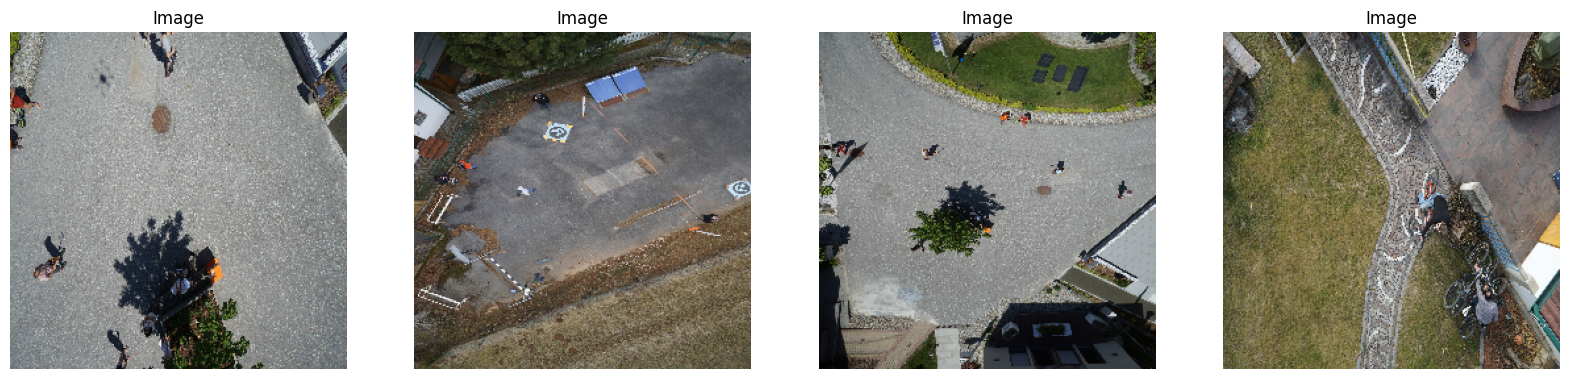

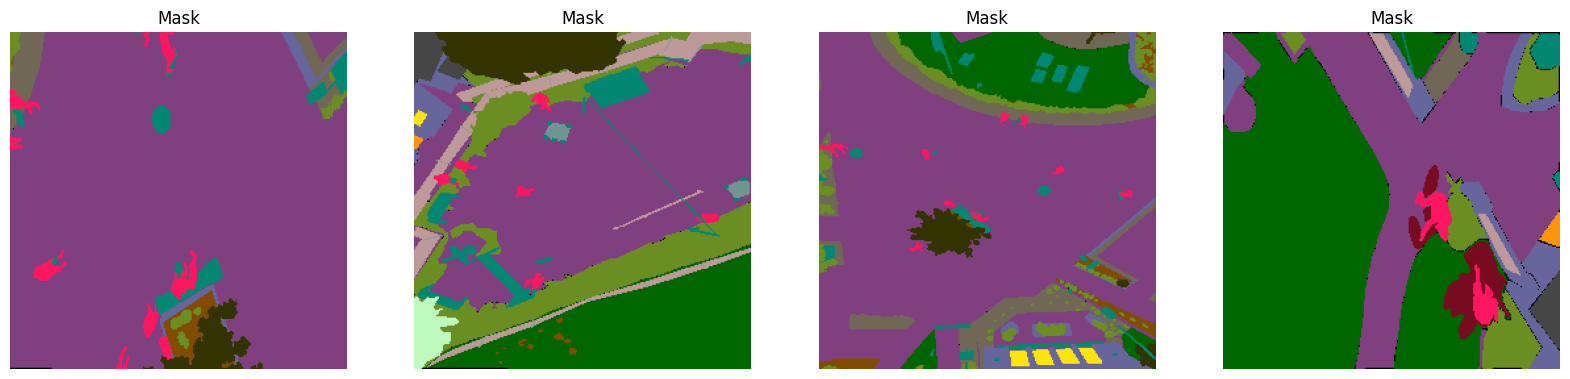

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import ImageOps


# Extract the image and mask from the TensorFlow pipeline
image, mask = next(iter(train))

# Convert the tensors to numpy arrays
image_np = image.numpy()
mask_np = mask.numpy()

plt.figure(figsize=(20, 10))  # Adjust the size as needed
for i in range(4):
    plt.subplot(2, 4, i + 1)
    plt.imshow(image_np[i])
    plt.title('Image')
    plt.axis('off')

# Display masks
plt.figure(figsize=(20, 10))  # Adjust the size as needed
for i in range(4):
    plt.subplot(2, 4, i + 1)
    plt.imshow(onehot_to_rgb(mask_np[i], id2rgb))
    plt.title('Mask')
    plt.axis('off')

plt.show()

In [ ]:
image.shape, mask.shape

(TensorShape([8, 256, 256, 3]), TensorShape([8, 256, 256, 24]))

# Build U-net Model

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers import Dropout, Conv2DTranspose, add

def build_fcn8s_model(vgg_weight_path = None):
  # Input
  input = layers.Input(shape=(img_size, img_size, 3))

  # Load VGG16 model without top layers, with or without weights
  vgg16 = VGG16(include_top=False, weights='imagenet' if vgg_weight_path is None else None, input_tensor=input)

  if vgg_weight_path:
      vgg16.load_weights(vgg_weight_path)

  # Set VGG16 layers to non-trainable
  vgg16.trainable = False

  f3 = vgg16.get_layer("block3_pool").output # shape: (64x64x256)
  f4 = vgg16.get_layer("block4_pool").output # shape: (32x32x512)
  f5 = vgg16.get_layer("block5_pool").output # shape: (16x16x512)

  # Fully Connected Layer
  f5_conv1 = Conv2D(4096, (7, 7), activation='relu', padding='same', name='fc_1')(f5)
  f5_conv2 = Conv2D(4096, (1, 1), activation='relu', padding='same', name='fc_2')(f5_conv1)
  f5_drop2 = Dropout(0.5)(f5_conv2)
  f5_conv3 = Conv2D(num_classes, (1, 1), activation='relu', padding='same', name='score-fr')(f5_drop2)

  # Upsampling x2 from (16x16x24 to 32x32x24)
  f5_conv3_x2 = Conv2DTranspose(filters=num_classes, kernel_size=4, strides=2,
                                use_bias=False, padding='same', activation='relu')(f5_conv3)
  f4_conv1 = Conv2D(filters=num_classes, kernel_size=1, padding='same',
                      activation=None)(f4)

  # Merging the 2 feature maps
  merge1 = add([f4_conv1, f5_conv3_x2])

  # Upsampling x2 from (32x32x24 to 64x64x24)
  merge1_x2 = Conv2DTranspose(filters=num_classes, kernel_size=4, strides=2,
                              use_bias=False, padding='same', activation='relu')(merge1)
  f3_conv1 = Conv2D(filters=num_classes, kernel_size=1, padding='same',
                    activation=None)(f3)

  # Merging the 2 feature maps
  merge2 = add([f3_conv1, merge1_x2])

  # Upsampling x8 from (64x64x24 to 512x512x24)
  outputs = Conv2DTranspose(filters=num_classes, kernel_size=16, strides=8,
                            padding='same', activation='softmax')(merge2)

  fcn8s_model = Model(inputs=input, outputs=outputs, name='fcn8s_model')

  return fcn8s_model

In [ ]:
fcn8s_model = build_fcn8s_model()
fcn8s_model.summary()

Model: "fcn8s_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 256, 256, 64)   │          1,792 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 256, 256, 64)   │         36,928 │ block1_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_pool               │ (None, 128, 128, 64)   │              0 │ block1_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv1 (Conv2D)     │ (None, 128, 128, 128)  │         73,856 │ block1_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv2 (Conv2D)     │ (None, 128, 128, 128)  │        147,584 │ block2_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 64, 64, 128)    │              0 │ block2_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv1 (Conv2D)     │ (None, 64, 64, 256)    │        295,168 │ block2_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv2 (Conv2D)     │ (None, 64, 64, 256)    │        590,080 │ block3_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv3 (Conv2D)     │ (None, 64, 64, 256)    │        590,080 │ block3_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_pool               │ (None, 32, 32, 256)    │              0 │ block3_conv3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv1 (Conv2D)     │ (None, 32, 32, 512)    │      1,180,160 │ block3_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv2 (Conv2D)     │ (None, 32, 32, 512)    │      2,359,808 │ block4_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv3 (Conv2D)     │ (None, 32, 32, 512)    │      2,359,808 │ block4_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_pool               │ (None, 16, 16, 512)    │              0 │ block4_conv3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv1 (Conv2D)     │ (None, 16, 16, 512)    │      2,359,808 │ block4_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv2 (Conv2D)     │ (None, 16, 16, 512)    │      2,359,808 │ block5_conv1[0][0]     │
├──────────────────────

 Total params: 134,543,264 (513.24 MB)

 Trainable params: 119,828,576 (457.11 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

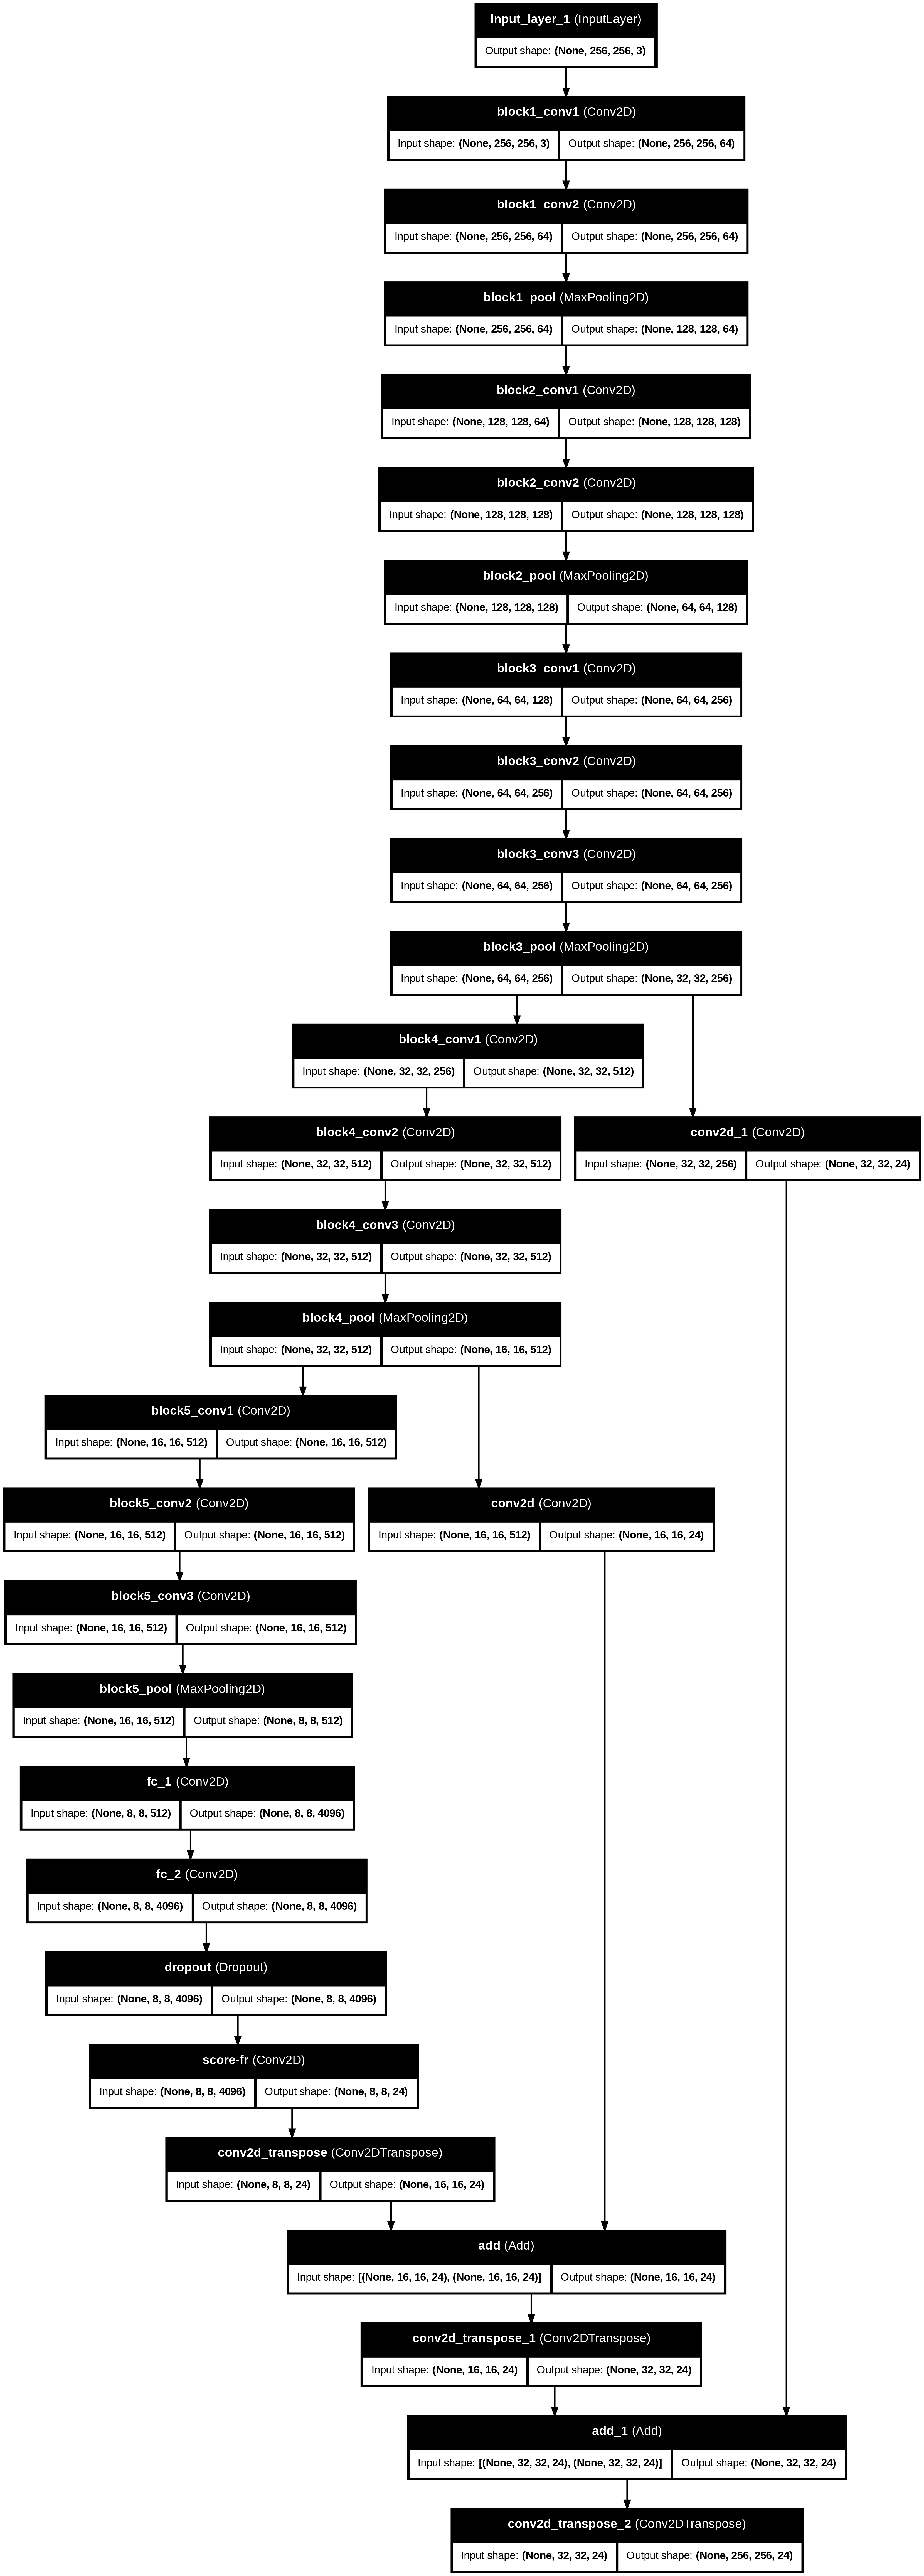

In [ ]:
plot_model(fcn8s_model, to_file='fcn8s_model.png', show_shapes=True, show_layer_names=True, expand_nested=True)

# 4.0 Training Model

In [ ]:
from tensorflow.keras.metrics import OneHotIoU, OneHotMeanIoU
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

num_classes = 24
target_class_ids = list(range(num_classes))

one_hot_iou = OneHotIoU(
    num_classes=num_classes,
    target_class_ids=target_class_ids,
    name='one_hot_iou'
)

fcn8s_model.compile(
    optimizer=Adam(learning_rate = 0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy',one_hot_iou]
)

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger

earlystop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    filepath = 'fcn8s_model.keras',
    save_best_only = True,
#     save_weights_only = False,
    monitor = 'val_loss',
    mode = 'auto',
    verbose = 1
)

"""
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.01 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.001, 20)

lr_scheduler = LearningRateScheduler(
    exponential_decay_fn,
    verbose=1
)
"""

csv_logger = CSVLogger('fcn8s_training_log.csv', append=True)

callbacks = [earlystop, csv_logger, checkpoint]


In [ ]:
hist = fcn8s_model.fit(train, epochs=eporchs, validation_data=val, verbose=1, callbacks=callbacks)

Epoch 1/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2933 - loss: 2.6435 - one_hot_iou: 0.0386
Epoch 1: val_loss improved from inf to 1.57999, saving model to fcn8s_model.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.2964 - loss: 2.6292 - one_hot_iou: 0.0391 - val_accuracy: 0.5532 - val_loss: 1.5800 - val_one_hot_iou: 0.0819
Epoch 2/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step - accuracy: 0.5334 - loss: 1.6004 - one_hot_iou: 0.0900
Epoch 2: val_loss improved from 1.57999 to 1.39261, saving model to fcn8s_model.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 34s 923ms/step - accuracy: 0.5339 - loss: 1.5987 - one_hot_iou: 0.0903 - val_accuracy: 0.5939 - val_loss: 1.3926 - val_one_hot_iou: 0.1057
Epoch 3/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - accuracy: 0.5785 - loss: 1.4192 - one_hot_iou: 0.1174
Epoch 3: val_loss improved from 1.39261 to 1.28736, saving model to fcn8s_model.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 31s 863ms/step - accuracy: 0.5787 - loss: 1.4182 - one_hot_iou: 0.117

In [ ]:
!pip install numba

from numba import cuda
device = cuda.get_current_device()
device.reset()

# 5.0 Evaluation

In [ ]:
evaluation = fcn8s_model.evaluate(test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.6846 - loss: 0.9705 - one_hot_iou: 0.2516


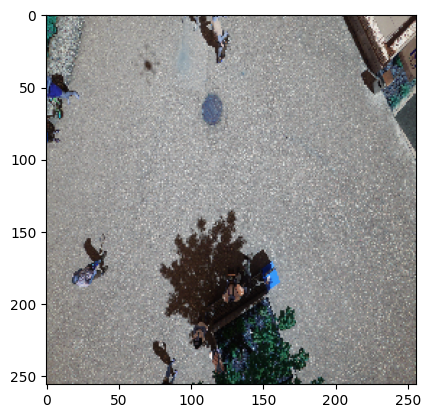

In [ ]:
img = cv2.imread('/content/drive/MyDrive/drone_dataset/dataset/semantic_drone_dataset/original_images/000.jpg')
resize = tf.image.resize(img, (img_size,img_size))
plt.imshow(resize.numpy().astype(int))
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


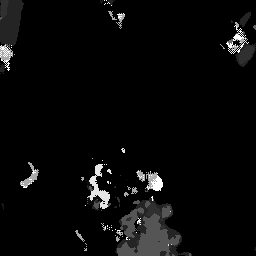

In [ ]:
yhat = unet_model.predict(np.expand_dims(resize/255,0))
from PIL import ImageOps
mask = np.argmax(yhat, axis=-1)
mask = np.squeeze(mask) # Remove the extra dimension
# Add a channel dimension to the mask
mask = np.expand_dims(mask, axis=-1)
img = ImageOps.autocontrast(keras.utils.array_to_img(mask))

display(img)

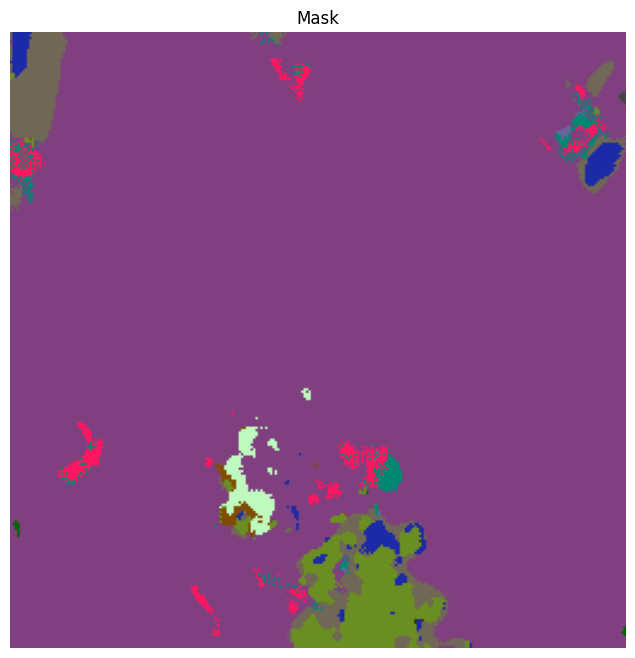

In [ ]:
plt.figure(figsize=(16, 8))  # Adjust the size as needed
plt.imshow(onehot_to_rgb(mask, id2rgb))
plt.title('Mask')
plt.axis('off')

plt.show()

In [ ]:
def onehot_to_rgb(mask, colormap):
    '''Function to decode encoded mask labels
        Inputs:
            mask - mask image matrix (height x width x 1) with class labels
            colormap - dictionary of label id to color
        Output: Decoded RGB image (height x width x 3)
    '''
    height, width, _ = mask.shape
    output = np.zeros((height, width, 3), dtype=np.uint8)

    for label, color in colormap.items():
        output[mask[:, :, 0] == label] = color

    return output

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


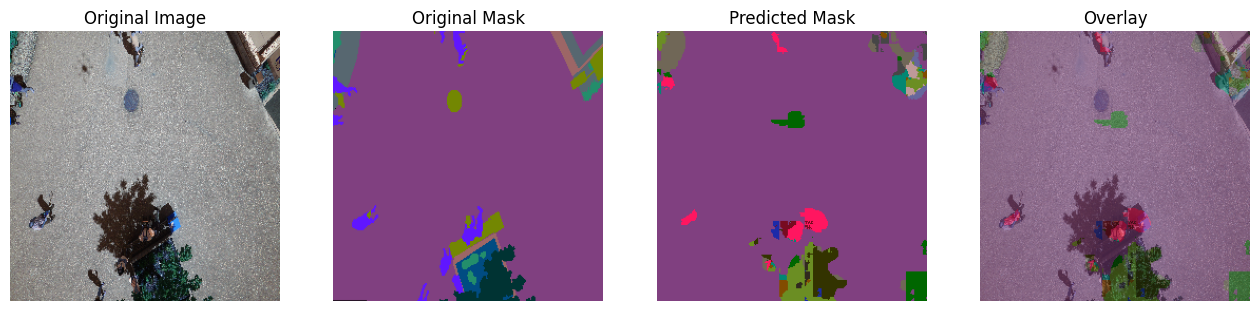

In [ ]:
img = cv2.imread('/content/drive/MyDrive/drone_dataset/dataset/semantic_drone_dataset/original_images/000.jpg')
mask = cv2.imread('/content/drive/MyDrive/drone_dataset/RGB_color_image_masks/RGB_color_image_masks/000.png')

img = tf.image.resize(img, (img_size, img_size))
mask = tf.image.resize(mask, (img_size, img_size))

# Predict the mask using the UNet model
yhat = fcn8s_model.predict(np.expand_dims(img/255, 0))
pri_mask = np.argmax(yhat, axis=-1)
pri_mask = np.squeeze(pri_mask)
pri_mask = np.expand_dims(pri_mask, axis=-1)

# Convert predicted mask to RGB
rgb_mask = onehot_to_rgb(pri_mask, id2rgb)

# Overlay the mask onto the original image
alpha = 0.5  # Transparency factor
overlay = cv2.addWeighted(img.numpy().astype(np.uint8), 1 - alpha, rgb_mask, alpha, 0)

# Display the original image, the original mask, the predicted mask, and the overlay
plt.figure(figsize=(16, 8))

plt.subplot(1, 4, 1)
plt.imshow(img.numpy().astype(int))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(mask.numpy().astype(int))
plt.title('Original Mask')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(rgb_mask)
plt.title('Predicted Mask')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(overlay)
plt.title('Overlay')
plt.axis('off')

plt.show()